## Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import pandas_profiling
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
%matplotlib inline


from tpot import TPOTClassifier
from tpot.config import classifier_config_dict

print('numpy version : ',np.__version__)
print('pandas version : ',pd.__version__)
print('seaborn version : ',sns.__version__)

numpy version :  1.20.1
pandas version :  1.1.3
seaborn version :  0.11.0


In [113]:
sns.set(rc={'figure.figsize':(20.7,8.27)})
sns.set_style("whitegrid")
sns.color_palette("dark")
#plt.style.use("fivethirtyeight")

[(0.0, 0.10980392156862745, 0.4980392156862745),
 (0.6941176470588235, 0.25098039215686274, 0.050980392156862744),
 (0.07058823529411765, 0.44313725490196076, 0.10980392156862745),
 (0.5490196078431373, 0.03137254901960784, 0.0),
 (0.34901960784313724, 0.11764705882352941, 0.44313725490196076),
 (0.34901960784313724, 0.1843137254901961, 0.050980392156862744),
 (0.6352941176470588, 0.20784313725490197, 0.5098039215686274),
 (0.23529411764705882, 0.23529411764705882, 0.23529411764705882),
 (0.7215686274509804, 0.5215686274509804, 0.0392156862745098),
 (0.0, 0.38823529411764707, 0.4549019607843137)]

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

def eval_classification(model, pred, xtrain, ytrain, xtest, ytest):
    print("Accuracy (Test Set): %.2f" % accuracy_score(ytest, pred))
    print("Precision (Test Set): %.2f" % precision_score(ytest, pred))
    print("Recall (Test Set): %.2f" % recall_score(ytest, pred))
    print("F1-Score (Test Set): %.2f" % f1_score(ytest, pred))
    
    fpr, tpr, thresholds = roc_curve(ytest, pred, pos_label=1) # pos_label: label yang kita anggap positive
    print("AUC: %.2f" % auc(fpr, tpr))
    
def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

## Load Data

In [136]:
data = pd.read_csv('Invistico_Airline.csv')
data.head()

,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Female,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,...,2,3,3,0,3,5,3,2,0,0.0
1,satisfied,Male,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,...,2,3,4,4,4,2,3,2,310,305.0
2,satisfied,Female,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,...,2,2,3,3,4,4,4,2,0,0.0
3,satisfied,Female,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,...,3,1,1,0,1,4,1,3,0,0.0
4,satisfied,Female,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,...,4,2,2,0,2,4,2,5,0,0.0


## Exploratory Data Analysis (EDA)

In [60]:
data_satisfaction = data.groupby(['satisfaction'])[['satisfaction']].count()
data_satisfaction['percentage'] = round((data_satisfaction/len(data))*100,2)
data_satisfaction = data_satisfaction.sort_values('percentage', ascending=False)
data_satisfaction

,satisfaction,percentage
satisfaction,,
satisfied,71087,54.73
dissatisfied,58793,45.27


#### membuat kolom baru untuk mengubah fitur satisfaction menjadi data numerik (0 dan 1)

In [137]:
data['satisfaction_label'] = data['satisfaction'].astype('category').cat.codes

#### cek jumlah dissatisfaction customer berdasarkan type of travel dan class

In [29]:
data1 = data[data['satisfaction_label'] == 0]

In [30]:
data2 = data1.groupby(['Type of Travel', 'Class'])['satisfaction_label'].count().reset_index(name='dissatisfaction').sort_values('dissatisfaction', ascending=False)
data2

,Type of Travel,Class,dissatisfaction
1,Business travel,Eco,17726
4,Personal Travel,Eco,17610
0,Business travel,Business,16634
2,Business travel,Eco Plus,2977
5,Personal Travel,Eco Plus,2415
3,Personal Travel,Business,1431


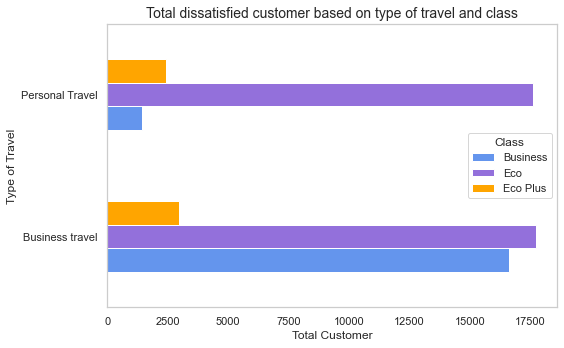

In [44]:
data2 = data1.groupby(['Type of Travel', 'Class'])['satisfaction_label'].count().reset_index().sort_values('satisfaction_label', ascending=False)
data3 = data2.pivot_table(index='Type of Travel', columns='Class', values='satisfaction_label')
data3.plot(kind='barh',figsize=(8,5), color =['cornflowerblue', 'mediumpurple', 'orange']);
plt.title('Total dissatisfied customer based on type of travel and class', fontsize = 14)
plt.xlabel('Total Customer', fontsize=12)
plt.ylabel('Type of Travel', fontsize=12)
plt.grid(b=None)
plt.tight_layout()

kesimpulan : total dissatisfied customer terbanyak terdapat pada bussiness travel eco dan personal travel eco

#### cek jumlah customer pada masing-masing type of travel dan class

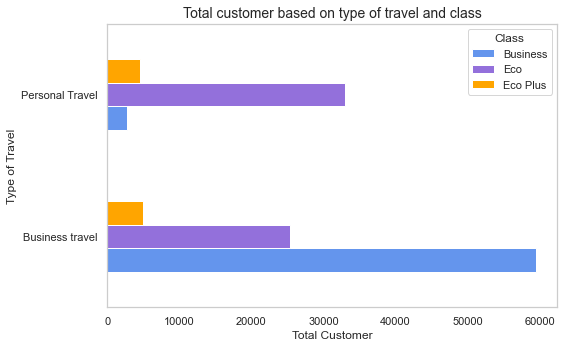

In [47]:
data4 = data.groupby(['Type of Travel', 'Class'])['satisfaction'].count().reset_index().sort_values('satisfaction', ascending=False)
data5 = data4.pivot_table(index='Type of Travel', columns='Class', values='satisfaction')
data5.plot(kind='barh',figsize=(8,5), color =['cornflowerblue', 'mediumpurple', 'orange']);
plt.title ('Total customer based on type of travel and class', fontsize=14)
plt.xlabel('Total Customer', fontsize = 12)
plt.ylabel('Type of Travel', fontsize=12)
plt.grid(b=None)
plt.tight_layout()

Top 3 total customer terbanyak :
- Business travel - business class
- Personal travel - eco class
- Business travel - eco class

#### Korelasi fitur berdasarkan business travel - eco class dan personal travel-eco class

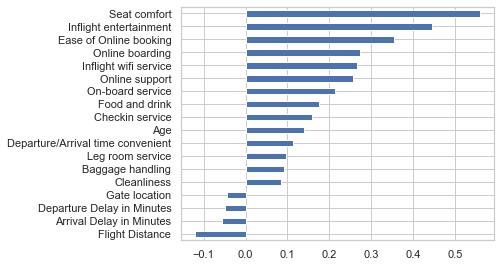

In [48]:
buss_eco = data[(data['Type of Travel'] == 'Business travel') & (data.Class == 'Eco')]
buss_eco.corr()['satisfaction_label'].sort_values().drop('satisfaction_label').plot(kind='barh', figsize=(5,4));

kesimpulan : fitur yang paling berkorelasi dengan business travel -eco class adalah seat comfort

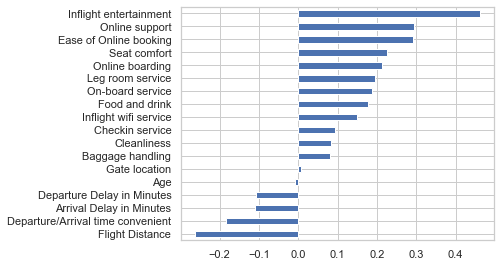

In [49]:
pers_eco = data[(data['Type of Travel'] == 'Personal Travel') & (data.Class == 'Eco')]
pers_eco.corr()['satisfaction_label'].sort_values().drop('satisfaction_label').plot(kind='barh', figsize=(5,4));

kesimpulan : fitur yang paling berkorelasi dengan personal travel - eco class adalah infligh entertaiment

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   satisfaction                       129880 non-null  object 
 1   Gender                             129880 non-null  object 
 2   Customer Type                      129880 non-null  object 
 3   Age                                129880 non-null  int64  
 4   Type of Travel                     129880 non-null  object 
 5   Class                              129880 non-null  object 
 6   Flight Distance                    129880 non-null  int64  
 7   Seat comfort                       129880 non-null  int64  
 8   Departure/Arrival time convenient  129880 non-null  int64  
 9   Food and drink                     129880 non-null  int64  
 10  Gate location                      129880 non-null  int64  
 11  Inflight wifi service              1298

In [57]:
data.describe()

,Age,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction_label
count,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129487.000000,129880.000000
mean,39.427957,1981.409055,2.838597,2.990645,2.851994,2.990422,3.249130,3.383477,3.519703,3.472105,3.465075,3.485902,3.695673,3.340807,3.705759,3.352587,14.713713,15.091129,0.547328
std,15.119360,1027.115606,1.392983,1.527224,1.443729,1.305970,1.318818,1.346059,1.306511,1.305560,1.270836,1.292226,1.156483,1.260582,1.151774,1.298715,38.071126,38.465650,0.497757
min,7.000000,50.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,1359.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,2.000000,3.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000,0.000000
50%,40.000000,1925.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,4.000000,0.000000,0.000000,1.000000
75%,51.000000,2544.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,5.000000,4.000000,5.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000,1.000000
max,85.000000,6951.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000,1.000000


#### cek data yang null

In [54]:
data.isnull().sum()

satisfaction                           0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Seat comfort                           0
Departure/Arrival time convenient      0
Food and drink                         0
Gate location                          0
Inflight wifi service                  0
Inflight entertainment                 0
Online support                         0
Ease of Online booking                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Cleanliness                            0
Online boarding                        0
Departure Delay in Minutes             0
Arrival Delay in Minutes             393
satisfaction_label                     0
dtype: int64

kesimpulan : terdapat 393 data yang null pada kolom Arrival Delay in Minutes 

#### cek data yang duplikat

In [55]:
data.duplicated().sum()

0

kesimpulan : tidak ada data duplikat

#### pemisahan data numerikal, categorical dan ordinal

In [72]:
numerical= ['Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']

In [73]:
categorical = ['Gender', 'Customer Type', 'Type of Travel', 'Class']

In [74]:
ordinal = ['Seat comfort', 'Departure/Arrival time convenient', 'Food and drink', 'Inflight wifi service', 'Inflight entertainment', 'Online support',
          'Gate location', 'Ease of Online booking', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding']

#### value counting data categorical

In [65]:
for col in categorical:
    print(f'''Value count kolom {col}:''')
    print(data[col].value_counts())
    print()

Value count kolom Gender:
Female    65899
Male      63981
Name: Gender, dtype: int64

Value count kolom Customer Type:
Loyal Customer       106100
disloyal Customer     23780
Name: Customer Type, dtype: int64

Value count kolom Type of Travel:
Business travel    89693
Personal Travel    40187
Name: Type of Travel, dtype: int64

Value count kolom Class:
Business    62160
Eco         58309
Eco Plus     9411
Name: Class, dtype: int64



kesimpulan : value count dari masing-masing feature hanya sedikit yaitu 2-3 value saja

#### value counting data ordinal 

In [64]:
for col in ordinal:
    print(f'''Value count kolom {col}:''')
    print(data[col].value_counts())
    print()

Value count kolom Seat comfort:
3    29183
2    28726
4    28398
1    20949
5    17827
0     4797
Name: Seat comfort, dtype: int64

Value count kolom Departure/Arrival time convenient:
4    29593
5    26817
3    23184
2    22794
1    20828
0     6664
Name: Departure/Arrival time convenient, dtype: int64

Value count kolom Food and drink:
3    28150
4    27216
2    27146
1    21076
5    20347
0     5945
Name: Food and drink, dtype: int64

Value count kolom Inflight wifi service:
4    31560
5    28830
3    27602
2    27045
1    14711
0      132
Name: Inflight wifi service, dtype: int64

Value count kolom Inflight entertainment:
4    41879
5    29831
3    24200
2    19183
1    11809
0     2978
Name: Inflight entertainment, dtype: int64

Value count kolom Online support:
4    41510
5    35563
3    21609
2    17260
1    13937
0        1
Name: Online support, dtype: int64

Value count kolom Gate location:
3    33546
4    30088
2    24518
1    22565
5    19161
0        2
Name: Gate location, 

kesimpulan : terdapat beberapa feature yang nilainya 0, sedangkan untuk rating ini kami asumsikan dari 1-5. Oleh karena itu, nantinya akan dilakukan treatment untuk data dengan nilai 0

### Univariate Analysis

#### distribusi data numerical

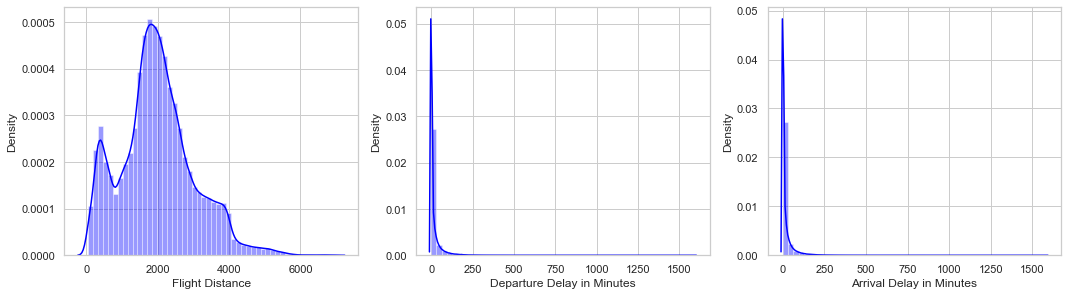

In [67]:
plt.figure(figsize=(15, 12))
for i in range(0, len(numerical)):
    plt.subplot(3, len(numerical), i+1)
    sns.distplot(data[nums[i]], color='blue')
    plt.tight_layout()

kesimpulan : grafiknya skewed positif, selanjutnya akan dilakukan treatment untuk mengubah distribusi datanya lebih normal.

### Multivariate Analysis

<AxesSubplot:>

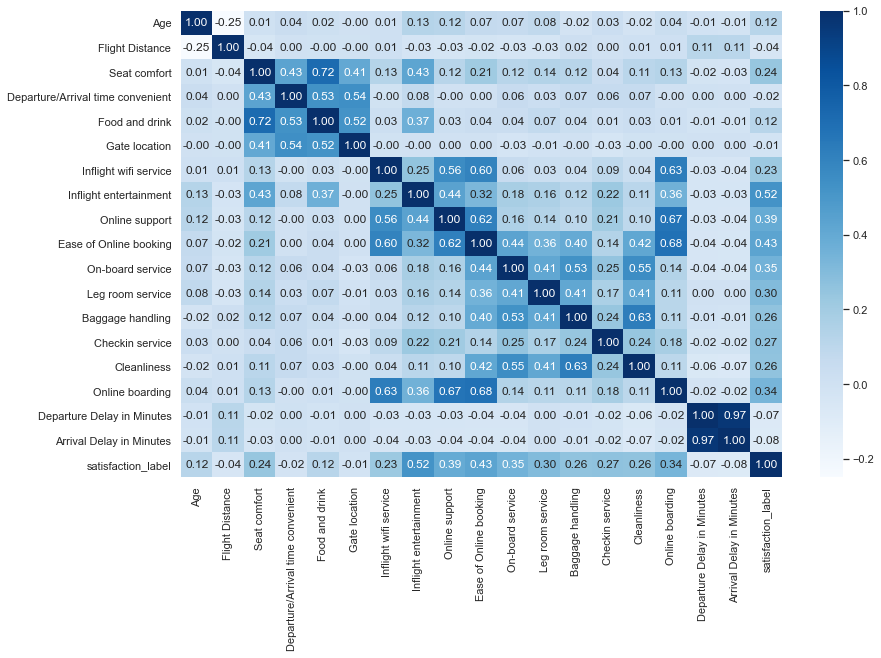

In [53]:
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), cmap='Blues', annot=True, fmt='.2f')

kesimpulan : 
- feature yang berkorelasi tinggi dengan target adalah inflight entertaiment dan ease of online booking
- feature yang berkorelasi kuat yaitu arrival delay dan departure delay. karena nilai korelasinya sangat tinggi mencapai 0.97, maka salah satu kolom akan dibuang.

## Data Preprocessing

#### hapus nilai yang null

In [138]:
data.dropna(inplace=True)

#### ubah nilai 0 pada data ordinal menjadi modus pada masing-masing kolom

In [139]:
for col in ordinal:
    modus = data[col].mode()[0]
    data[col] = data[col].replace(0, modus)

#### treatment outliers dengan log transfrom

In [140]:
for var in numerical:
    data[var]= (data[var]+1).apply(np.log)

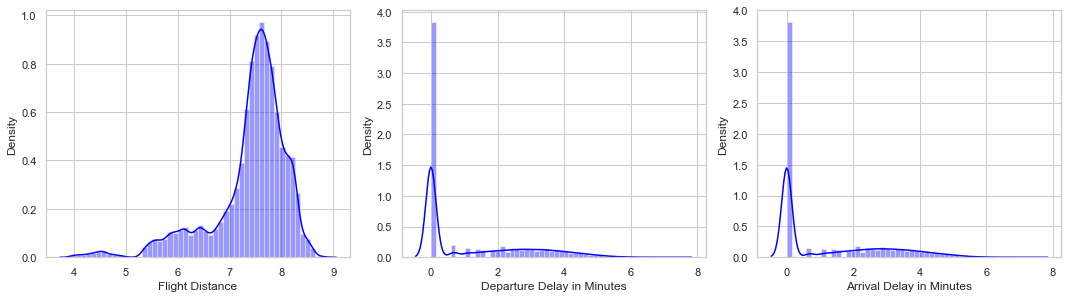

In [78]:
plt.figure(figsize=(15, 12))
for i in range(0, len(numerical)):
    plt.subplot(3, len(numerical), i+1)
    sns.distplot(data[nums[i]], color='blue')
    plt.tight_layout()

kesimpulan : sudah dilakukan treatment untuk outliers dengan menggunakan logaritma transformation dan hasilnya distribusi data sedikit lebih normal.

#### Scaling data numerical dengan MinMaxScaler

In [141]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
for var in numerical:
    data[var]= MinMaxScaler().fit_transform(data[var].values.reshape(len(data), 1))

## Feature Engineering

#### menggunakan feature one hot encoding untuk data categorical

In [142]:
for cat in categorical:
    onehots = pd.get_dummies(data[cat], prefix=cat)
    data = data.join(onehots)

## Modelling

#### split data training dan data testing

In [143]:
X = data.drop(columns=['satisfaction', 'Gender', 'Customer Type', 'Type of Travel', 'Class', 'Arrival Delay in Minutes', 'satisfaction_label'])
y = data['satisfaction_label'] # target / label

#Splitting the data into Train and Test
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

#### Model 1 : Logistic Regression

In [88]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
eval_classification(model, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.85
Precision (Test Set): 0.86
Recall (Test Set): 0.88
F1-Score (Test Set): 0.87
AUC: 0.85


##### accuracy score

In [86]:
print('Train score: ' + str(model.score(X_train, y_train))) 
print('Test score:' + str(model.score(X_test, y_test)))

Train score: 0.8526001795557443
Test score:0.8527685535562591


#### Model 2 : KNN

In [87]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train) 

# Prediction & Evaluation
y_pred = knn.predict(X_test)
eval_classification(knn, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.91
Precision (Test Set): 0.93
Recall (Test Set): 0.90
F1-Score (Test Set): 0.91
AUC: 0.91


##### accuracy score

In [89]:
print('Train score: ' + str(knn.score(X_train, y_train)))
print('Test score:' + str(knn.score(X_test, y_test))) 

Train score: 0.9321742656073522
Test score:0.9074059772955441


#### Model 3 : Decision Tree

In [90]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train,y_train)

y_pred = model.predict(X_test)
eval_classification(model, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.93
Precision (Test Set): 0.94
Recall (Test Set): 0.94
F1-Score (Test Set): 0.94
AUC: 0.93


##### accuracy score

In [91]:
print('Train score: ' + str(model.score(X_train, y_train))) 
print('Test score:' + str(model.score(X_test, y_test))) 

Train score: 1.0
Test score:0.9338172831878909


#### Model 4 : AdaBoost

In [92]:
from sklearn.ensemble import AdaBoostClassifier
ab = AdaBoostClassifier(random_state=42)
ab.fit(X_train,y_train)

y_pred = ab.predict(X_test)
eval_classification(ab, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.88
Precision (Test Set): 0.89
Recall (Test Set): 0.89
F1-Score (Test Set): 0.89
AUC: 0.88


##### accuracy score

In [93]:
print('Train score: ' + str(ab.score(X_train, y_train))) 
print('Test score:' + str(ab.score(X_test, y_test))) 

Train score: 0.881145681491278
Test score:0.8821530620125106


#### Model 5 : Random Forest

In [94]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train,y_train)

y_pred = rf.predict(X_test)
eval_classification(rf, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.96
Precision (Test Set): 0.97
Recall (Test Set): 0.95
F1-Score (Test Set): 0.96
AUC: 0.96


##### accuracy score

In [95]:
print('Train score: ' + str(rf.score(X_train, y_train))) 
print('Test score:' + str(rf.score(X_test, y_test))) 

Train score: 0.9999903464653583
Test score:0.9554019615414318


#### Model 6 : XGBoost

In [144]:
from xgboost import XGBClassifier, XGBRegressor
xg = XGBClassifier(random_state=42)
xg.fit(X_train, y_train)

y_pred = xg.predict(X_test)
eval_classification(xg, y_pred, X_train, y_train, X_test, y_test)

[19:22:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy (Test Set): 0.96
Precision (Test Set): 0.97
Recall (Test Set): 0.95
F1-Score (Test Set): 0.96
AUC: 0.96


##### accuracy score

In [97]:
print('Train score: ' + str(xg.score(X_train, y_train))) 
print('Test score:' + str(xg.score(X_test, y_test))) 

Train score: 0.9683750205137611
Test score:0.9570237083944706


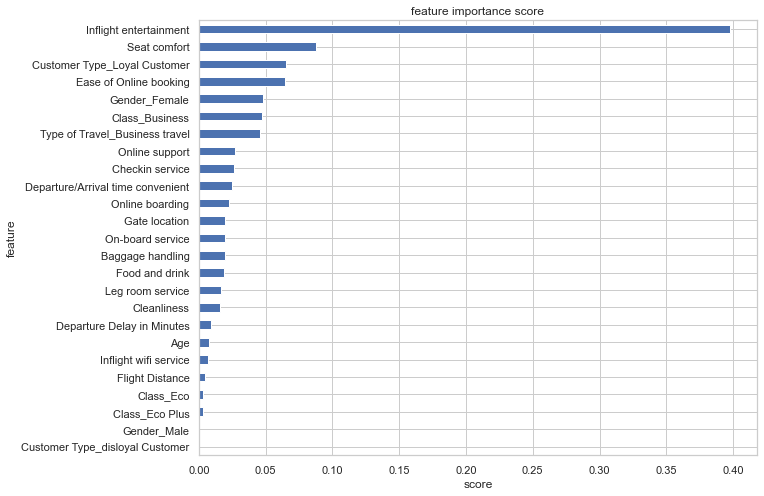

In [145]:
show_feature_importance(xg)

kesimpulan : karena model dengan nilai precision paling tinggi yaitu Random Forest dan XGBoost dengan nilai 0.97. Selanjutnya, akan dilakukan hyperparameter tuning

#### Hyperparameter Tuning Random Forest

In [99]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#List Hyperparameters yang akan diuji
hyperparameters = dict(
                       n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)], # Jumlah subtree
                       bootstrap = [True],
                       criterion = ['gini','entropy'],
                       max_depth = [int(x) for x in np.linspace(10, 110, num = 11)],  # Maximum kedalaman tree
                       min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 10, num = 5)], # Jumlah minimum samples pada node agar boleh di split menjadi leaf baru
                       min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 10, num = 5)], # Jumlah minimum samples pada leaf agar boleh terbentuk leaf baru
                       max_features = ['auto', 'sqrt', 'log2'], # Jumlah feature yg dipertimbangkan pada masing-masing split
                       n_jobs = [-1], # Core untuk parallel computation. -1 untuk menggunakan semua core
                      )

# Init
rf = RandomForestClassifier(random_state=42)
rf_tuned = RandomizedSearchCV(rf, hyperparameters, cv=5, random_state=42, scoring='precision')
rf_tuned.fit(X_train,y_train)

# Predict & Evaluation
y_pred = rf_tuned.predict(X_test)#Check performa dari model
eval_classification(rf_tuned, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.96
Precision (Test Set): 0.96
Recall (Test Set): 0.95
F1-Score (Test Set): 0.96
AUC: 0.96


##### accuracy score

In [100]:
print('Train score: ' + str(rf_tuned.score(X_train, y_train))) 
print('Test score:' + str(rf_tuned.score(X_test, y_test))) 

Train score: 0.9994170538253635
Test score:0.9643421998562185


In [101]:
print('Best n_estimators:', rf_tuned.best_estimator_.get_params()['n_estimators'])
print('Best criterion:', rf_tuned.best_estimator_.get_params()['criterion'])
print('Best max_depth:', rf_tuned.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', rf_tuned.best_estimator_.get_params()['min_samples_split'])
print('Best min_samples_leaf:', rf_tuned.best_estimator_.get_params()['min_samples_leaf'])
print('Best max_features:', rf_tuned.best_estimator_.get_params()['max_features'])

Best n_estimators: 400
Best criterion: gini
Best max_depth: 110
Best min_samples_split: 4
Best min_samples_leaf: 1
Best max_features: log2


##### feature importance

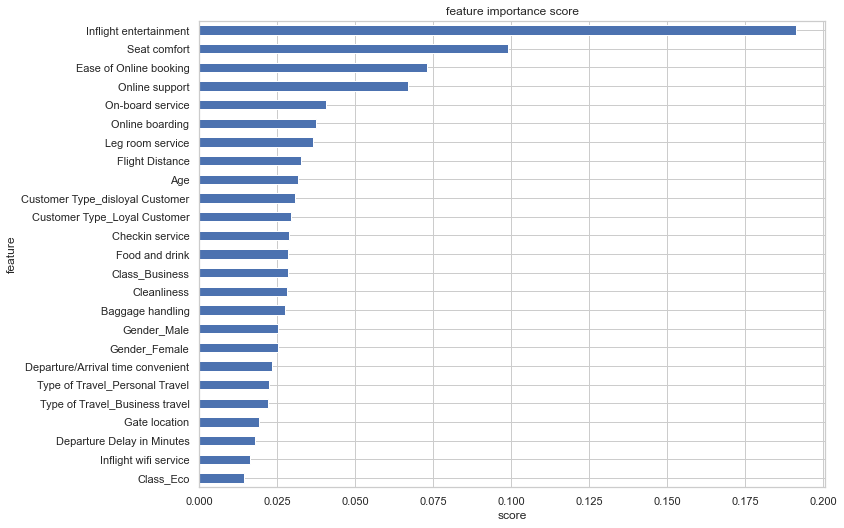

In [102]:
show_feature_importance(rf_tuned.best_estimator_)

#### Hyperparameter Tuning XGBoost

In [103]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import numpy as np

hyperparameters = {
                    'max_depth' : [int(x) for x in np.linspace(10, 110, num = 11)],
                    'min_child_weight' : [int(x) for x in np.linspace(1, 20, num = 11)],
                    'gamma' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'tree_method' : ['auto', 'exact', 'approx', 'hist'],

                    'colsample_bytree' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'eta' : [float(x) for x in np.linspace(0, 1, num = 100)],

                    'lambda' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'alpha' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'verbosity': [0]
                    }


# Init
xg = XGBClassifier(random_state=42)
xg_tuned = RandomizedSearchCV(xg, hyperparameters, cv=5, random_state=42, scoring='precision')
xg_tuned.fit(X_train,y_train)

# Predict & Evaluation
y_pred = xg_tuned.predict(X_test)#Check performa dari model
eval_classification(xg_tuned, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.96
Precision (Test Set): 0.97
Recall (Test Set): 0.96
F1-Score (Test Set): 0.96
AUC: 0.96


##### accuracy score

In [104]:
print('Train score: ' + str(xg_tuned.score(X_train, y_train))) 
print('Test score:' + str(xg_tuned.score(X_test, y_test)))

Train score: 0.9885207037307713
Test score:0.9686599423631124


In [105]:
print('Best max_depth:', xg_tuned.best_estimator_.get_params()['max_depth'])
print('Best min_child_weight:', xg_tuned.best_estimator_.get_params()['min_child_weight'])
print('Best gamma:', xg_tuned.best_estimator_.get_params()['gamma'])
print('Best tree_method:', xg_tuned.best_estimator_.get_params()['tree_method'])
print('Best colsample_bytree:', xg_tuned.best_estimator_.get_params()['colsample_bytree'])
print('Best eta:', xg_tuned.best_estimator_.get_params()['eta'])
print('Best lambda:', xg_tuned.best_estimator_.get_params()['lambda'])
print('Best alpha:', xg_tuned.best_estimator_.get_params()['alpha'])

Best max_depth: 50
Best min_child_weight: 20
Best gamma: 0.1
Best tree_method: hist
Best colsample_bytree: 0.8
Best eta: 0.20202020202020204
Best lambda: 0.4
Best alpha: 0.7000000000000001


##### feature importance

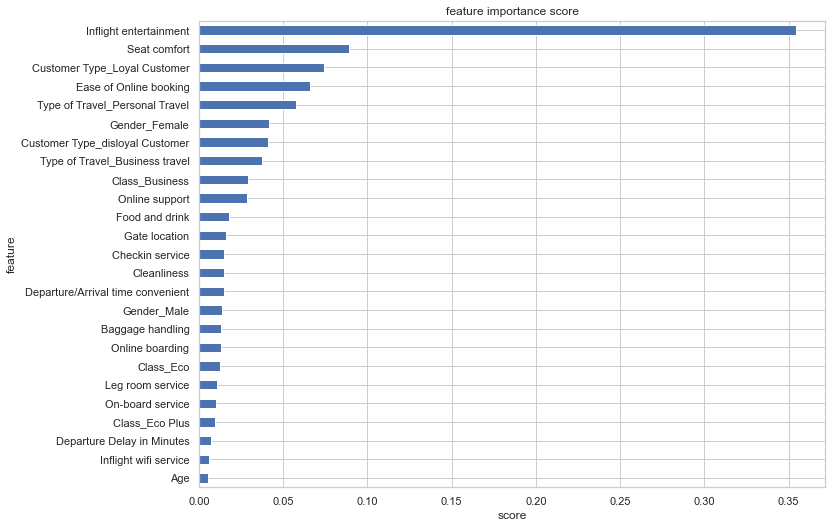

In [106]:
show_feature_importance(xg_tuned.best_estimator_)

## Simulasi perubahan 2 feature dan pengaruhnya pada tingkat kepuasan customer

In [82]:
data_awal = data.drop(columns=['Gender', 'Customer Type', 'Type of Travel', 'Class', 'Arrival Delay in Minutes'])

In [83]:
#filter data personal travel dengan eco class
pers_eco = data[(data['Type of Travel']== 'Personal Travel') & (data['Class']== 'Eco')] 

In [84]:
#hapus data kategorikal dan arrival delay
pers_eco = pers_eco.drop(columns=['Gender', 'Customer Type', 'Type of Travel', 'Class', 'Arrival Delay in Minutes'])

In [85]:
#semua kolom yang sudah difilter dijadikan sampel 
# kolom satisfaction dan satisfaction label dihapus
sample_pers_eco = pers_eco.sample(frac=1, random_state=42)
x_pers_eco = sample_pers_eco.drop(columns=['satisfaction', 'satisfaction_label'])
x_pers_eco.reset_index(inplace=True, drop=True)
x_pers_eco

,Age,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,...,Departure Delay in Minutes,Gender_Female,Gender_Male,Customer Type_Loyal Customer,Customer Type_disloyal Customer,Type of Travel_Business travel,Type of Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus
0,53,0.673069,3,4,3,2,2,3,2,2,...,0.000000,0,1,1,0,0,1,0,1,0
1,21,0.747628,2,4,2,2,2,2,2,2,...,0.325210,0,1,1,0,0,1,0,1,0
2,19,0.711522,4,4,4,1,1,4,1,1,...,0.000000,1,0,1,0,0,1,0,1,0
3,70,0.358478,5,3,3,3,5,5,5,5,...,0.587348,1,0,1,0,0,1,0,1,0
4,41,0.783013,5,2,2,2,5,5,5,5,...,0.337011,1,0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32881,16,0.701746,4,4,4,4,1,4,4,4,...,0.553008,1,0,1,0,0,1,0,1,0
32882,53,0.773884,1,5,1,5,2,1,2,2,...,0.419217,0,1,1,0,0,1,0,1,0
32883,57,0.782843,2,4,2,3,4,2,4,4,...,0.297994,0,1,1,0,0,1,0,1,0
32884,41,0.789621,1,1,1,1,5,1,5,5,...,0.000000,0,1,1,0,0,1,0,1,0


In [86]:
#kolom inflight entertaiment diganti ratingnya dengan nilai 4 atau 5 (random)
new_rate = np.random.choice(range(4,6), size = x_pers_eco.shape[0])
for i in ['Inflight entertainment']:
    x_pers_eco[i] = x_pers_eco[i].map(dict(zip(x_pers_eco[i].unique(), new_rate)))

In [87]:
#kemudian sample di predict menggunakan XGBoost
y_pers_eco = xg.predict(x_pers_eco)
y_pers_eco = pd.DataFrame(y_pers_eco.tolist())

In [88]:
#hasil yang sudah di predict dimasukkan hasilnya di kolom satisfaction label
df_pers_eco = x_pers_eco.copy()
df_pers_eco['satisfaction_label'] = y_pers_eco
df_pers_eco

,Age,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,...,Gender_Female,Gender_Male,Customer Type_Loyal Customer,Customer Type_disloyal Customer,Type of Travel_Business travel,Type of Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus,satisfaction_label
0,53,0.673069,3,4,3,2,2,4,2,2,...,0,1,1,0,0,1,0,1,0,0
1,21,0.747628,2,4,2,2,2,5,2,2,...,0,1,1,0,0,1,0,1,0,0
2,19,0.711522,4,4,4,1,1,5,1,1,...,1,0,1,0,0,1,0,1,0,1
3,70,0.358478,5,3,3,3,5,4,5,5,...,1,0,1,0,0,1,0,1,0,1
4,41,0.783013,5,2,2,2,5,4,5,5,...,1,0,1,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32881,16,0.701746,4,4,4,4,1,5,4,4,...,1,0,1,0,0,1,0,1,0,1
32882,53,0.773884,1,5,1,5,2,4,2,2,...,0,1,1,0,0,1,0,1,0,0
32883,57,0.782843,2,4,2,3,4,5,4,4,...,0,1,1,0,0,1,0,1,0,0
32884,41,0.789621,1,1,1,1,5,4,5,5,...,0,1,1,0,0,1,0,1,0,1


In [89]:
#jumlah dissatisfied customer yang awalnya 17610 berkurang menjadi 14973
df_pers_eco['satisfaction_label'].value_counts()

1    18550
0    14336
Name: satisfaction_label, dtype: int64

### business travel

In [90]:
# filter data business travel dengan eco class
bus_eco = data[(data['Type of Travel']== 'Business travel') & (data['Class']== 'Eco')]

In [91]:
#hapus data kategorikal dan arrival delay
bus_eco = bus_eco.drop(columns=['Gender', 'Customer Type', 'Type of Travel', 'Class', 'Arrival Delay in Minutes'])

In [92]:
#semua kolom yang sudah difilter dijadikan sampel 
# kolom satisfaction dan satisfaction label dihapus
sample_bus_eco = bus_eco.sample(frac=1, random_state=42)
x_bus_eco = sample_bus_eco.drop(columns=['satisfaction', 'satisfaction_label'])
x_bus_eco.reset_index(inplace=True, drop=True)
x_bus_eco

,Age,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,...,Departure Delay in Minutes,Gender_Female,Gender_Male,Customer Type_Loyal Customer,Customer Type_disloyal Customer,Type of Travel_Business travel,Type of Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus
0,54,0.369154,4,3,3,3,2,2,3,4,...,0.553008,1,0,1,0,1,0,0,1,0
1,42,0.746512,2,1,1,1,1,1,1,1,...,0.188014,1,0,0,1,1,0,0,1,0
2,22,0.807194,5,5,5,3,2,5,2,2,...,0.000000,0,1,0,1,1,0,0,1,0
3,25,0.757887,4,1,3,3,5,3,5,5,...,0.000000,0,1,0,1,1,0,0,1,0
4,60,0.728772,4,3,3,3,4,4,4,4,...,0.282020,0,1,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25226,36,0.647272,4,4,4,4,4,4,4,4,...,0.000000,1,0,1,0,1,0,0,1,0
25227,35,0.822951,2,2,2,5,2,2,3,2,...,0.000000,1,0,0,1,1,0,0,1,0
25228,20,0.767011,1,1,1,2,1,1,1,1,...,0.000000,1,0,0,1,1,0,0,1,0
25229,48,0.302894,2,2,5,2,4,3,3,2,...,0.000000,1,0,1,0,1,0,0,1,0


In [93]:
#kolom seat comfort diganti ratingnya dengan nilai 4 atau 5 (random)
new_rate = np.random.choice(range(4,6), size = x_bus_eco.shape[0])
for i in ['Seat comfort']:
    x_bus_eco[i] = x_bus_eco[i].map(dict(zip(x_bus_eco[i].unique(), new_rate)))

In [94]:
#kemudian sample di predict menggunakan XGBoost
y_bus_eco = xg.predict(x_bus_eco)
y_bus_eco = pd.DataFrame(y_bus_eco.tolist())

In [95]:
#hasil yang sudah di predict dimasukkan hasilnya di kolom satisfaction label
df_bus_eco = x_bus_eco.copy()
df_bus_eco['satisfaction_label'] = y_bus_eco

In [96]:
#jumlah dissatisfied customer yang awalnya 17726 berkurang menjadi 7393
df_bus_eco['satisfaction_label'].value_counts()

1    21030
0     4201
Name: satisfaction_label, dtype: int64

#### gabungan hasil 2 prediksi diatas dengan data awal

In [97]:
#filter data personal travel dengan class eco, kemudian hapus
df_gabungan = data[~((data['Type of Travel']== 'Personal Travel') & (data['Class']== 'Eco'))]

In [98]:
#filter data business travel dengan class eco, kemudian hapus
df_gabungan = df_gabungan[~((df_gabungan['Type of Travel']== 'Business travel') & (df_gabungan['Class']== 'Eco'))]

In [99]:
#hapus data kategorikal dan arrival delay
df_gabungan = df_gabungan.drop(columns=['Gender', 'Customer Type', 'Type of Travel', 'Class', 'Arrival Delay in Minutes'])

In [100]:
#gabungkan sample pers-eco yang sudah dipredict ke df_gabungan
df_compare = df_gabungan.append(df_pers_eco).drop(columns='satisfaction')

In [101]:
#kemudian gabungkan juga sample bus-eco yang sudah dipredict
df_compare = df_compare.append(df_bus_eco)

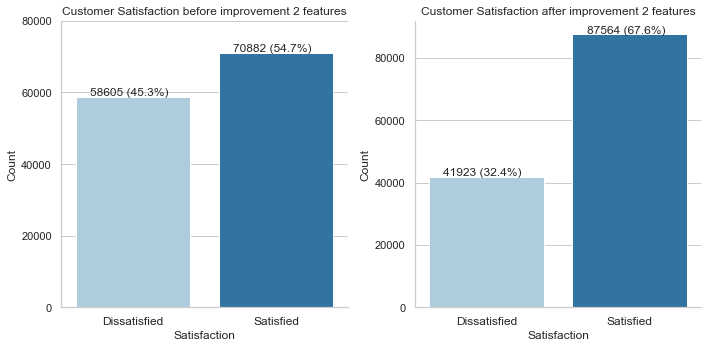

In [131]:
#bandingkan tingkat satisfaction customer data awal dengan data baru yang sudah dipredict ulang
fig,ax = plt.subplots(1,2,figsize=(10,5))

g = sns.countplot(data=data_awal, x='satisfaction_label',ax=ax[0], palette = 'Paired')
ax[0].set_title('Customer Satisfaction before improvement 2 features', fontsize = 12)
ax[0].set_yticks(range(0,100000,20000))
ax[0].set_xlabel('Satisfaction', fontsize=12)
ax[0].set_xticklabels(['Dissatisfied','Satisfied'], fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)

for p in g.patches:
    g.annotate(str(p.get_height())+' ('+str((p.get_height()/len(data_awal)*100).round(1))+'%)',(p.get_x()+0.1,p.get_height()+400))

g = sns.countplot(data=df_compare, x='satisfaction_label',ax=ax[1], palette = 'Paired')
ax[1].set_title('Customer Satisfaction after improvement 2 features', fontsize=12)
ax[1].set_yticks(range(0,100000,20000))
ax[1].set_xlabel('Satisfaction', fontsize=12)
ax[1].set_xticklabels(['Dissatisfied','Satisfied'], fontsize=12)
ax[1].set_ylabel('Count', fontsize=12)

for p in g.patches:
    g.annotate(str(p.get_height())+' ('+str((p.get_height()/len(df_compare)*100).round(1))+'%)',(p.get_x()+0.1,p.get_height()+400))

plt.tight_layout()
sns.despine()